https://www.iqvia.com/insights/the-iqvia-institute/reports/prescription-opioid-trends-in-the-united-states

https://www.iqvia.com/blogs/2019/07/the-opioid-crisis-the-data-the-science-and-the-humanity

https://www.cdc.gov/mmwr/preview/mmwrhtml/mm6450a3.htm

https://www.cdc.gov/drugoverdose/fatal/dashboard/index.html



In [15]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
#import plotly.express as px
import os
import re

In [16]:
df = pd.read_csv('prescriber-info.csv')
opioids = pd.read_csv('opioids.csv')

In [17]:
# replace spaces and hypens with periods

opioids["Drug Name"] = opioids["Drug Name"].replace('-', '.', regex=True)
opioids["Drug Name"] = opioids["Drug Name"].replace(' ', '.', regex=True)

#opioids names matching with the drug columns from prescriber info
set(opioids['Drug Name']) & set(df.columns.tolist())

{'ACETAMINOPHEN.CODEINE',
 'FENTANYL',
 'HYDROCODONE.ACETAMINOPHEN',
 'HYDROMORPHONE.HCL',
 'METHADONE.HCL',
 'MORPHINE.SULFATE',
 'MORPHINE.SULFATE.ER',
 'OXYCODONE.ACETAMINOPHEN',
 'OXYCODONE.HCL',
 'OXYCONTIN',
 'TRAMADOL.HCL'}

In [18]:
tables = pd.read_html(r'https://www.infoplease.com/us/postal-information/state-abbreviations-and-state-postal-codes') # get list of state abbreviations
states = tables[0]['Postal Code'] # 51 entries, including DC
df['State'] = np.where(df['State'].isin(states), df['State'], 'Other')
df = df[~df.State.str.contains('Other')] #include DC but exclude PR, VI, ZZ, AE, GU, AA # 24759 rows

In [19]:
df.shape

(24759, 256)

In [20]:
pd.set_option("display.max_rows", None)
#df = df.loc[:, df.any()]
#df['Specialty'].value_counts()

In [21]:
# clean specialty values
df.loc[df['Specialty'].str.contains('Nurse'), 'Specialty'] = 'Nurse'
df.loc[df['Specialty'].str.contains('rectal', case=False), 'Specialty'] = 'Colorectal Surgery'
df.loc[df['Specialty'].str.contains('Physical'), 'Specialty'] = 'Physical Medicine'
df.loc[df['Specialty'].str.contains('Psychologist'), 'Specialty'] = 'Psychologist'
df.loc[df['Specialty'].str.contains('Pain'), 'Specialty'] = 'Pain Management'
df.loc[df['Specialty'].str.contains('Cardiac'), 'Specialty'] = 'Cardiology'
df.loc[df['Specialty'].str.contains('Oncology'), 'Specialty'] = 'Oncology'
df.loc[df['Specialty'].str.contains('Psychiatry', case=False), 'Specialty'] = 'Psychiatry'
df.loc[df['Specialty'].str.contains('Radiology'), 'Specialty'] = 'Radiology'
df.loc[df['Specialty'].str.contains('neuro', case=False), 'Specialty'] = 'Neurology'
df.loc[df['Specialty'].str.contains('Oral'), 'Specialty'] = 'Oral Surgery'
df.loc[df['Specialty'].str.contains('Radiology'), 'Specialty'] = 'Radiology'
df.loc[df['Specialty'].str.contains('Sports'), 'Specialty'] = 'Physical Medicine'
df.loc[df['Specialty'].str.contains('ortho', case=False), 'Specialty'] = 'Orthopedic Surgery'
df.loc[df['Specialty'].str.contains('Plastic'), 'Specialty'] = 'Plastic Surgery'
df.loc[df['Specialty'].str.contains('Family'), 'Specialty'] = 'Family Medicine'
df.loc[df.groupby('Specialty').Specialty.transform('count').lt(10), 'Specialty'] = 'Other'
df = df[~df.Specialty.str.contains('Other')] # exclude Other --> 24679 rows
df.loc[df['Specialty'] == 'Student in an Organized Health Care Education/Training Program', 'Specialty'] = 'Medical Students, Interns, Residents'
#df['Specialty'].value_counts()

In [39]:
#create DF for regional analysis instead of state analysis 
table = pd.read_html(r'https://www.infoplease.com/us/states/regions-of-the-us') # get list of regions and states

#rename columns
table[0].columns = ['Region','States']

#get region into list
region_list = table[0]['Region'].tolist()

#Make state list from pd.Series
state_list = [ i.split(", ") for i in table[0]['States'].tolist()]
#add DC to list
state_list[1].append('District of Columbia')
#Create dictionary region as key and states (lists) as values
region_dict = {region: states for region, states in zip(region_list, state_list)}
#explode regions for every state
region_df = pd.Series(region_dict, name='States').rename_axis('Region').explode().reset_index()


tables = pd.read_html(r'https://www.infoplease.com/us/postal-information/state-abbreviations-and-state-postal-codes') # get list of state abbreviations
states_tables = tables[0][['State Name/District','Postal Code']] # 51 entries, including DC
#merge table
region_df = region_df.merge(states_tables, how = 'left', left_on = 'States', right_on = 'State Name/District' )
del region_df['State Name/District']

region_df.head(25)

,Region,States,Postal Code
0,New England,Connecticut,CT
1,New England,Maine,ME
2,New England,Massachusetts,MA
3,New England,New Hampshire,NH
4,New England,Rhode Island,RI
5,New England,Vermont,VT
6,Middle Atlantic,Delaware,DE
7,Middle Atlantic,Maryland,MD
8,Middle Atlantic,New Jersey,NJ
9,Middle Atlantic,New York,NY


In [23]:
#Create df for state and count every row, grouped by state
df_state = df[['State','NPI']].groupby('State').count()
df_state.reset_index(level = 0,inplace = True)
df_state.columns = ['State','Total Drug Prescribers']
#Create df for opioids and add all 1's, grouped by specialty and join them
df_opioids = pd.DataFrame(df.groupby(['State'])['Opioid.Prescriber'].sum())
df_opioids.reset_index(level = 0,inplace = True)
df_opioids.columns = ['State','Total Opioid Prescribers']
df_state = df_state.merge(df_opioids, how = 'left', on = 'State')
#Create nonopioids prescribers column by state and sort by descending order for opioids prescribers
df_state['Total Nonopioid Prescribers'] = df_state['Total Drug Prescribers'] - df_state['Total Opioid Prescribers']
df_state['Percentage of Opioids Prescribers'] = df_state['Total Opioid Prescribers']/df_state['Total Drug Prescribers']
df_state =  df_state.sort_values(by=['Total Opioid Prescribers'], ascending=False)
df_state.head(35)

,State,Total Drug Prescribers,Total Opioid Prescribers,Total Nonopioid Prescribers,Percentage of Opioids Prescribers
4,CA,2551,1457,1094,0.571149
43,TX,1499,949,550,0.633089
34,NY,1948,874,1074,0.448665
9,FL,1562,869,693,0.556338
38,PA,1206,679,527,0.563018
35,OH,980,563,417,0.574490
14,IL,1001,555,446,0.554446
22,MI,871,553,318,0.634902
27,NC,777,498,279,0.640927
10,GA,609,397,212,0.651888


In [24]:
df_specialty_region = df[['Specialty','State','NPI']].groupby(['Specialty','State']).count()
df_specialty_region = df_specialty_region.reset_index()
df_specialty_region.columns = ['Specialty','State','Total Drug Prescribers']
#join by region and sum
df_specialty_region = df_specialty_region.merge(region_df, how = 'left', left_on = 'State', right_on = 'Postal Code')


df_specialty_region = df_specialty_region.drop(['State','Postal Code','States'], axis=1)

df_specialty_region = df_specialty_region[['Specialty', 'Region', 'Total Drug Prescribers']]

df_specialty_region = pd.DataFrame(df_specialty_region.groupby(['Specialty','Region'])['Total Drug Prescribers'].sum())


df_specialty_region = df_specialty_region.reset_index()


In [25]:
df_opi_region = pd.DataFrame(df.groupby(['Specialty','State'])['Opioid.Prescriber'].sum())
df_opi_region = df_opi_region.reset_index() #level = 0,inplace = True

df_opi_region = df_opi_region.merge(region_df, how = 'left', left_on = 'State', right_on = 'Postal Code')

df_opi_region = df_opi_region.drop(['State','Postal Code','States'], axis=1)

df_opi_region.columns = ['Specialty', 'Total Opioid Prescribers', 'Region']
df_opi_region = df_opi_region[['Specialty','Region' , 'Total Opioid Prescribers']]

df_opi_region = pd.DataFrame(df_opi_region.groupby(['Specialty','Region'])['Total Opioid Prescribers'].sum())

df_opi_region = df_opi_region.reset_index()

df_specialty_region = df_specialty_region.merge(df_opi_region, how ='left', on =['Specialty','Region'])
df_specialty_region =  df_specialty_region.sort_values(by=['Total Opioid Prescribers'], ascending=False)
df_specialty_region['Total Nonopioid Prescribers'] = df_specialty_region['Total Drug Prescribers'] - df_specialty_region['Total Opioid Prescribers']



In [26]:
display(df_specialty_region.head(15))

,Specialty,Region,Total Drug Prescribers,Total Opioid Prescribers,Total Nonopioid Prescribers
56,Family Medicine,South,801,717,84
54,Family Medicine,Midwest,738,659,79
112,Internal Medicine,South,800,628,172
58,Family Medicine,West,608,538,70
109,Internal Medicine,Middle Atlantic,681,495,186
114,Internal Medicine,West,573,448,125
110,Internal Medicine,Midwest,552,423,129
145,Nurse,South,800,393,407
32,Dentist,South,703,383,320
53,Family Medicine,Middle Atlantic,396,331,65


In [27]:
#pd.set_option("display.max_columns", None)
#pd.options.display.max_colwidth= 100
#

In [28]:
df_specialty = df[['Specialty','NPI']].groupby('Specialty').count()
df_specialty.reset_index(level = 0,inplace = True)
df_specialty.columns = ['Specialty','Total Drug Prescribers']
df_specialty.head(10)

,Specialty,Total Drug Prescribers
0,Allergy/Immunology,119
1,Anesthesiology,138
2,Cardiology,727
3,Colorectal Surgery,34
4,Critical Care (Intensivists),29
5,Dentist,2771
6,Dermatology,343
7,Emergency Medicine,1081
8,Endocrinology,152
9,Family Medicine,2977


In [29]:
#df.loc[df['Opioid.Prescriber']> 0,['Specialty','NPI']].groupby('Specialty').count()
df_opioids = pd.DataFrame(df.groupby(['Specialty'])['Opioid.Prescriber'].sum())
df_opioids.reset_index(level = 0,inplace = True)
df_opioids.columns = ['Specialty','Total Opioid Prescribers']
df_specialty = df_specialty.merge(df_opioids, how = 'left', on = 'Specialty')


In [30]:
df_specialty['Total Nonopioid Prescribers'] = df_specialty['Total Drug Prescribers'] - df_specialty['Total Opioid Prescribers']
df_specialty =  df_specialty.sort_values(by=['Total Opioid Prescribers'], ascending=False)
df_specialty.loc[48, 'Specialty'] = 'Medical Students, Interns, Residents'
#df_specialty.at['Student in an Organized Health Care Education/Training Program', 'Specialty'] = 'Medical Students, Interns, Residents'

In [31]:
df_specialty.head(50)

,Specialty,Total Drug Prescribers,Total Opioid Prescribers,Total Nonopioid Prescribers
9,Family Medicine,2977,2633,344
19,Internal Medicine,3162,2399,763
25,Nurse,2629,1371,1258
39,Physician Assistant,1838,1261,577
5,Dentist,2771,1056,1715
7,Emergency Medicine,1081,1040,41
31,Orthopedic Surgery,605,589,16
12,General Surgery,484,439,45
27,Oncology,418,369,49
24,Neurology,455,270,185


In [32]:
df_specialty_percentage = df_specialty.copy()
df_specialty_percentage['Percentage of Opioids Prescribers'] = df_specialty_percentage['Total Opioid Prescribers']/df_specialty_percentage['Total Drug Prescribers']
df_specialty_percentage =  df_specialty_percentage.sort_values(by=['Percentage of Opioids Prescribers'], ascending=False)
#df_specialty_percentage = df_specialty_percentage[1:]



In [33]:
overdoses = pd.read_csv('overdoses.csv')
overdoses = overdoses[['State', 'Abbrev', 'Population', 'Deaths']]

#add DC
dc = {'State': ['District of Columbia'],
      'Abbrev': ['DC'],
      'Population': ['658,893'],
      'Deaths': ['96']}
dc = pd.DataFrame(dc).astype('object')

overdoses = pd.concat([overdoses,dc], ignore_index = True)
overdoses["Population"] = overdoses["Population"].apply(lambda x: int(re.sub(',','', x)))
overdoses["Deaths"] = overdoses["Deaths"].apply(lambda x: int(re.sub(',','', x)))
overdoses["DeathsPer100K"] = round(overdoses["Deaths"]/overdoses["Population"]*100000,2)

In [34]:
overdoses

,State,Abbrev,Population,Deaths,DeathsPer100K
0,Alabama,AL,4833722,723,14.96
1,Alaska,AK,735132,124,16.87
2,Arizona,AZ,6626624,1211,18.27
3,Arkansas,AR,2959373,356,12.03
4,California,CA,38332521,4521,11.79
5,Colorado,CO,5268367,899,17.06
6,Connecticut,CT,3596080,623,17.32
7,Delaware,DE,925749,189,20.42
8,Florida,FL,19552860,2634,13.47
9,Georgia,GA,9992167,1206,12.07


In [35]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import re

In [36]:
#import website
f = requests.get('https://www.cdc.gov/drugoverdose/rxrate-maps/state2014.html')
soup = BeautifulSoup(f.text)

In [42]:

#import column headers
Ourlist = soup.find("thead",{"class":"thead-dark"})
inner_col = [item.text for item in Ourlist.find_all('th')]
#import dataframe rows as list
Ourlist = soup.find("tbody")
inner_text = [item.text for item in Ourlist.find_all('td')]

#slice list after every 3rd element
lst = [inner_text[x:x+3] for x in range(0, len(inner_text), 3)]
#put dataframe together
dispensing_df = pd.DataFrame(lst, columns =inner_col)
dispensing_df['Opioid Dispensing Rate per 100']=dispensing_df['Opioid Dispensing Rate per 100'].astype('float64')

#DC is not a state
#dispensing_df = dispensing_df[~dispensing_df.State.str.contains('District of Columbia')]

#reset index after deleting DC
#dispensing_df.reset_index(drop = True)

#Opioid Dispensing Rate per 100 == Opioid Dispensing Rate Per 100 Persons
new_overdoses_df = pd.merge(overdoses, dispensing_df,  how='right', left_on=['State'], right_on = ['State'])

del new_overdoses_df['State Abbreviation']
#new_overdoses_df =  new_overdoses_df.sort_values(by=['Opioid Dispensing Rate per 100'], ascending=False)
new_overdoses_df =  new_overdoses_df.sort_values(by=['DeathsPer100K'], ascending=False)
new_overdoses_df

,State,Abbrev,Population,Deaths,DeathsPer100K,Opioid Dispensing Rate per 100
48,West Virginia,WV,1854304,627,33.81,126.4
31,New Mexico,NM,2085287,547,26.23,71.5
29,New Hampshire,NH,1323459,334,25.24,79.6
17,Kentucky,KY,4395295,1077,24.50,110.0
35,Ohio,OH,11570808,2744,23.71,89.5
39,Rhode Island,RI,1051511,247,23.49,72.8
38,Pennsylvania,PA,12773801,2732,21.39,79.9
44,Utah,UT,2900872,603,20.79,78.8
7,Delaware,DE,925749,189,20.42,91.0
36,Oklahoma,OK,3850568,777,20.18,110.9


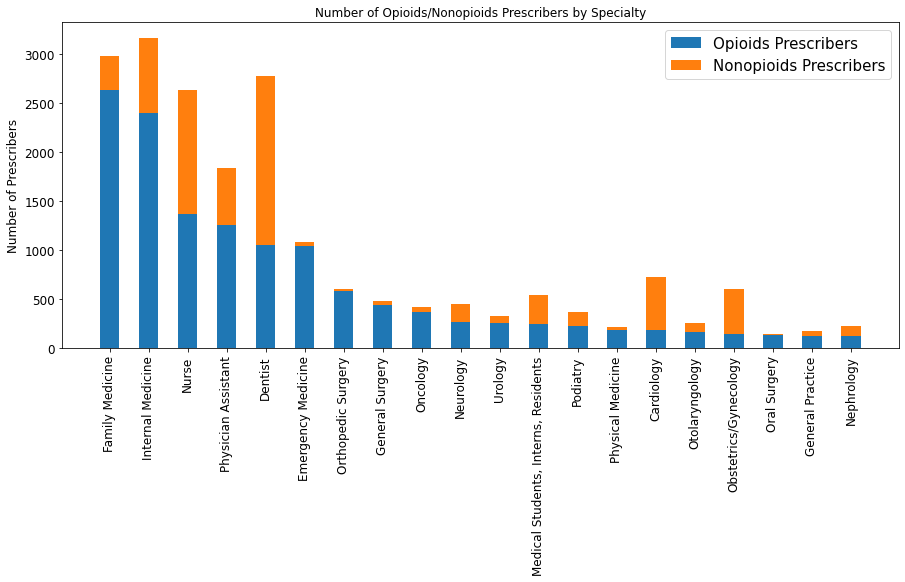

In [24]:
x = list(df_specialty['Specialty'][:20])
y_opi_prescriber = list(df_specialty['Total Opioid Prescribers'][:20])
y_nonopi_prescriber = list(df_specialty['Total Nonopioid Prescribers'][:20])
width = 0.5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
fig.set_size_inches( 15, 6)
ax.bar(x, y_opi_prescriber, width,label='Opioids Prescribers')
ax.bar(x, y_nonopi_prescriber, width, bottom=y_opi_prescriber, label='Nonopioids Prescribers')

ax.set_ylabel('Number of Prescribers')
ax.set_title('Number of Opioids/Nonopioids Prescribers by Specialty')
ax.legend()
plt.legend(fontsize=15)
plt.xticks(rotation = 90, fontsize = 12)
plt.ylabel("Number of Prescribers", fontsize=12)
plt.yticks(fontsize=12)
plt.show()


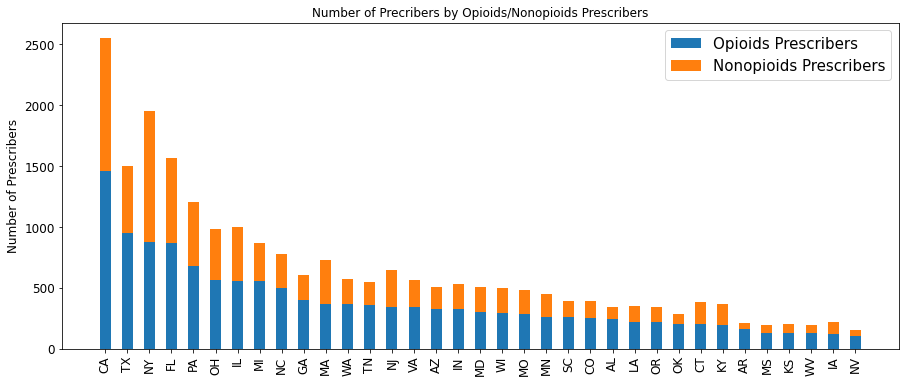

In [25]:

x = list(df_state['State'][:35])
y_opi_prescriber = list(df_state['Total Opioid Prescribers'][:35])
y_nonopi_prescriber = list(df_state['Total Nonopioid Prescribers'][:35])
y_opi_percentage = list(df_state['Percentage of Opioids Prescribers'][:35])
width = 0.5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
fig.set_size_inches( 15, 6)
ax.bar(x, y_opi_prescriber, width,label='Opioids Prescribers')
ax.bar(x, y_nonopi_prescriber, width, bottom=y_opi_prescriber, label='Nonopioids Prescribers')

#ax.set_ylabel('Number of Prescribers')
ax.set_title('Number of Precribers by Opioids/Nonopioids Prescribers', fontsize = 12)
ax.legend()
plt.legend(fontsize=15)
plt.xticks(rotation = 90, fontsize = 12)
plt.ylabel("Number of Prescribers", fontsize=12)
plt.yticks(fontsize=12)
plt.show()


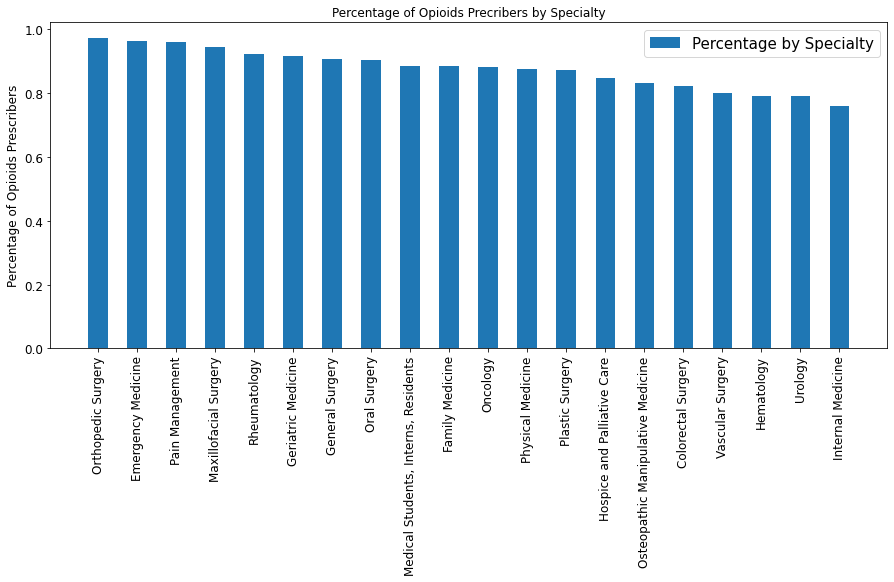

In [26]:


x = list(df_specialty_percentage['Specialty'][:20])
#y_opi_prescriber = list(df_state['Total Opioid Prescribers'][:20])
#y_nonopi_prescriber = list(df_state['Total Nonopioid Prescribers'][:20])
y_opi_percentage = list(df_specialty_percentage['Percentage of Opioids Prescribers'][:20])
width = 0.5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
fig.set_size_inches( 15, 6)
ax.bar(x, y_opi_percentage, width,label='Percentage by Specialty')
#ax.bar(x, y_nonopi_prescriber, width, bottom=y_opi_prescriber, label='Nonopioids Prescribers')


ax.set_title('Percentage of Opioids Precribers by Specialty', fontsize = 12)
ax.legend()
plt.legend(fontsize=15)
plt.xticks(rotation = 90, fontsize = 12)
plt.ylabel("Percentage of Opioids Prescribers", fontsize=12)
plt.yticks(fontsize=12)
plt.show()
